In [1]:
import torch
# import torch.distributions as dist
import os
import shutil
import argparse
from tqdm import tqdm
import time
from collections import defaultdict
import pandas as pd
from im2mesh import config
from im2mesh.checkpoints import CheckpointIO
from im2mesh.utils.io import export_pointcloud
from im2mesh.utils.visualize import visualize_data
from im2mesh.utils.voxels import VoxelGrid
from im2mesh import config, data
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene
import matplotlib.pyplot as plt


/home/jw/anaconda3/envs/mesh_funcspace/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jw/uni/ml3d/occupancy_networks/im2mesh/onet/models/convnext.py:159: UserWarning: Overwriting convnext_tiny in registry with im2mesh.onet.models.convnext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False,in_22k=False, **kwargs):
/home/jw/uni/ml3d/occupancy_networks/im2mesh/onet/models/convnext.py:168: UserWarning: Overwriting convnext_small in registry with im2mesh.onet.models.convnext.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_small(pretrained=False,in_22k=False, **kwargs):
/home/jw/uni/ml3d/occupancy

In [2]:
cfg = config.load_config('configs/img/onet_test.yaml')
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")

out_dir = cfg['training']['out_dir']
generation_dir = os.path.join(out_dir, cfg['generation']['generation_dir'])
out_time_file = os.path.join(generation_dir, 'time_generation_full.pkl')
out_time_file_class = os.path.join(generation_dir, 'time_generation.pkl')

batch_size = cfg['training']['batch_size']
input_type = cfg['data']['input_type']
vis_n_outputs = cfg['generation']['vis_n_outputs']
if vis_n_outputs is None:
    vis_n_outputs = -1

# Dataset
dataset = config.get_dataset('test', cfg, return_idx=True)

# Model
model = config.get_model(cfg, device=device, dataset=dataset)

checkpoint_io = CheckpointIO(out_dir, model=model)
checkpoint_io.load(cfg['test']['model_file']);

/home/jw/anaconda3/envs/mesh_funcspace/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jw/anaconda3/envs/mesh_funcspace/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


out/img/onet/model_best.pt
=> Loading checkpoint from local file...


In [3]:
model

OccupancyNetwork(
  (decoder): DecoderCBatchNorm(
    (fc_p): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
    (block0): CResnetBlockConv1d(
      (bn_0): CBatchNorm1d(
        (conv_gamma): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (conv_beta): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (bn_1): CBatchNorm1d(
        (conv_gamma): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (conv_beta): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (block1): CResnetBlockConv1d(
      (bn_0): CBatchNorm1d(
        (conv_gamma): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (conv_beta): Conv1d(256,

In [4]:
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [5]:
for batch in train_loader:
    sample = batch
    break

In [6]:
# inputs
points = sample['points']
images = sample['inputs']
masks = sample['inputs.mask']
occs = sample['points.occ']

# prediction
pred = model(points.to(device), images.to(device)).logits.sigmoid()

In [10]:
# mask entire batch
images[masks.expand_as(images) == 0] = 1

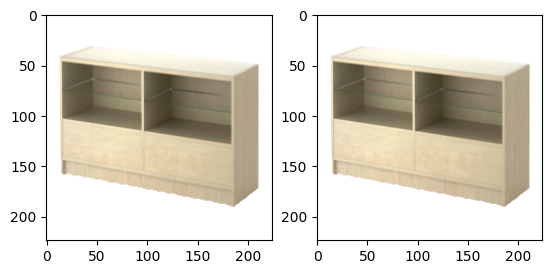

Points: 1024 GT size: 85 (8.3%), Pred size: 77
Points BBox Span: tensor([1.0980, 1.0935, 1.0993])
    GT BBox Span: tensor([0.9896, 0.4435, 0.2723])
Percentage: tensor([90.1251, 40.5532, 24.7669])


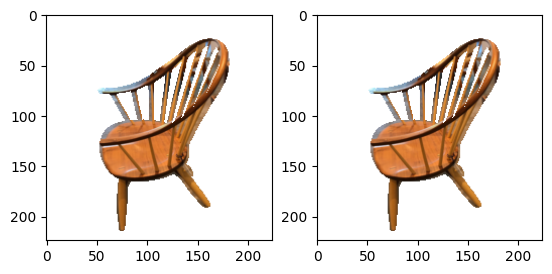

Points: 1024 GT size: 14 (1.4%), Pred size: 5
Points BBox Span: tensor([1.0986, 1.0996, 1.0994])
    GT BBox Span: tensor([0.4845, 0.6080, 0.4883])
Percentage: tensor([44.0981, 55.2922, 44.4196])


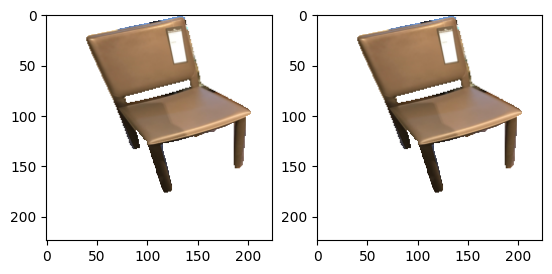

Points: 1024 GT size: 14 (1.4%), Pred size: 17
Points BBox Span: tensor([1.0980, 1.0991, 1.0978])
    GT BBox Span: tensor([0.4349, 0.5089, 0.6412])
Percentage: tensor([39.6047, 46.2985, 58.4069])


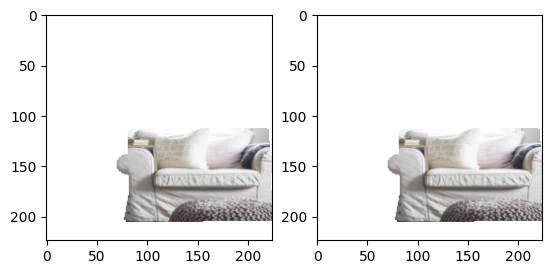

Points: 1024 GT size: 313 (30.6%), Pred size: 303
Points BBox Span: tensor([1.0997, 1.0986, 1.0964])
    GT BBox Span: tensor([0.9593, 0.8178, 0.8469])
Percentage: tensor([87.2357, 74.4471, 77.2375])


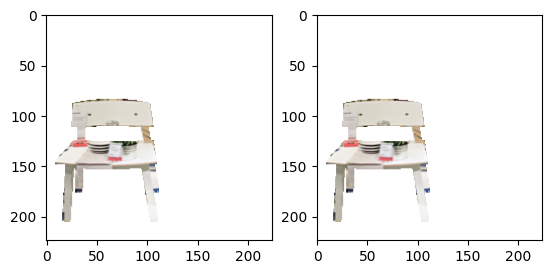

Points: 1024 GT size: 18 (1.8%), Pred size: 5
Points BBox Span: tensor([1.0987, 1.0984, 1.0992])
    GT BBox Span: tensor([0.5384, 0.8635, 0.5511])
Percentage: tensor([49.0044, 78.6118, 50.1334])


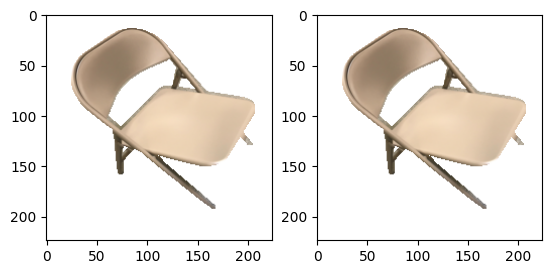

Points: 1024 GT size: 8 (0.8%), Pred size: 3
Points BBox Span: tensor([1.0993, 1.0956, 1.0982])
    GT BBox Span: tensor([0.5555, 0.8326, 0.5624])
Percentage: tensor([50.5324, 75.9939, 51.2129])


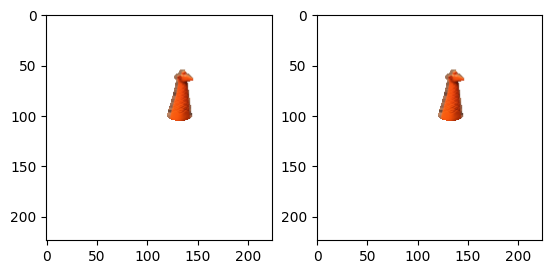

Points: 1024 GT size: 37 (3.6%), Pred size: 32
Points BBox Span: tensor([1.0982, 1.0989, 1.0997])
    GT BBox Span: tensor([0.2857, 0.8577, 0.2269])
Percentage: tensor([26.0193, 78.0477, 20.6348])


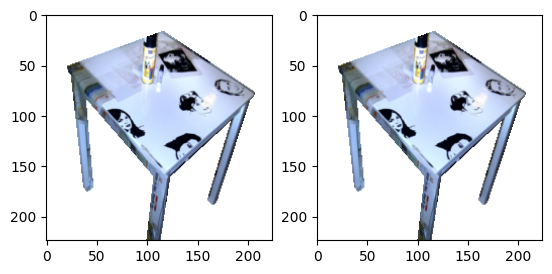

Points: 1024 GT size: 51 (5.0%), Pred size: 59
Points BBox Span: tensor([1.0959, 1.0981, 1.0984])
    GT BBox Span: tensor([0.9588, 0.8627, 0.9521])
Percentage: tensor([87.4952, 78.5647, 86.6851])


In [11]:
for i in range(len(points)):
    # plot img
    plt.figure()
    plt.imshow(images[i].permute(1, 2, 0).numpy())

    plt.show()

    pc_gt = points[i][occs[i] == 1]
    pc_pred = points[i][(pred[i] > 0.5).cpu().numpy()]

    print(f"Points: {points[i].shape[0]} GT size: {pc_gt.shape[0]} ({pc_gt.shape[0]/points[i].shape[0]*100:0.1f}%), Pred size: {pc_pred.shape[0]}")
    bbox_min, bbox_max = points[i].min(0)[0], points[i].max(0)[0]
    pc_bbox_min, pc_bbox_max = pc_gt.min(0)[0], pc_gt.max(0)[0]
    print(f"Points BBox Span: {bbox_max - bbox_min}")
    print(f"    GT BBox Span: {pc_bbox_max - pc_bbox_min}")
    print(f"Percentage: {((pc_bbox_max - pc_bbox_min)/(bbox_max - bbox_min)*100)}")

    plot_scene({
        "Pointcloud": {
            "All": Pointclouds(points=[points[i]]),
            "GT": Pointclouds(points=[pc_gt]),
            **({"Pred": Pointclouds(points=[pc_pred])} if pc_pred.shape[0] > 0 else {})
        }
    }, pointcloud_marker_size=5).show()